# Credit card spend Prediction and Identifying the key drivers

### Business Problem

- Find the key factors driving the Spend (Primary card + Secondary card)
- Predict credict limit for new customers based on the credit card spend

**Approach** : 

**1 Pre-Modelling and Data Audit** <br>
- 1.1 Pandas profiling
- 1.2 Identifying the catagorical variables
- 1.3 Finding the variables which can be considered for modelling
- 1.4 Analysing the spend <br>

**2 Data Preparation** <br>
- 2.1 Outlier and missing value treatment
- 2.2 Determing the assumptions

**3 Feature Reduction** <br>
- 3.1 Featuring reduction considering only Xs
> - Correlation between Xs
  - Principal Component Analysis (PCA)
  - Variance Inflation Factor (VIF)
- 3.2 Feature reduction based on X and Y 
> - Recursive feature elimination (RFE)
  - F Regression
  - Select K-best
  - Decision Tree feature importance
- 3.3 Combining the all the selected features and splitting the data into train and test
  
**4 Model Implementation + tuning hyper parameters + model evaluation**<br>
- Regularized regression techniques
> - Ridge
  - Lasso
  - Elastic net
- Ensemble methods
> - Random Forest
  - XGBoost
- Support Vector Regressor (SVR)

**5 Finding the Optimum Credit Limit for the card holders**

**6 Identifying the Key Drivers of the Spend**
- Implementing the stats model Linear Regression
> - Identifying the important variables from the Model Summary
  - Math Equation (for Excel tool)
- Summarizing the Key drivers of the spend (Positive and Negative drivers)

**7 Conclusion**

### ----------------------------------------------------------------------------------------------------------------------------

**Importing the Libraries**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

**Importing the dataset**

In [2]:
data_original = pd.read_excel('credit_spend_data.xlsx')

In [3]:
data = data_original.copy()

In [4]:
data.shape

(5000, 130)

**Check for duplicate rows**

In [5]:
data.duplicated().value_counts()

False    5000
dtype: int64

### Identifying the important features from Decision Tree and Business understanding

The Important features identified by applying the Decision Tree Regressor on the entire dataset with Best parameters <br> (in descending order of importance) <br>

card	income	inccat	card2	hourstv	lninc	polview	debtinc	age	othdebt	carvalue	lnlongmon	lnothdebt	ed	lnlongten	cardten	address	lncreddebt	longmon	card2type	tollmon	lnwiremon	cardbenefit	internet	cars	commute	equipten

In [6]:
# These variables are manually picked from the Dataset as per the Business
# After several iterations the following variables are qualified for the data preparation
key_vars = ['age','ed','jobcat','retire','income','debtinc','creddebt','othdebt','default','marital','reason','card','card2','cardspent','card2spent','active','tenure','churn','cardbenefit','gender']

In [7]:
len(key_vars)

20

In [8]:
data_old = data.copy()
data = data[key_vars]

### ----------------------------------------------------------------------------------------------------------------------------

## 1 Pre-Modelling and Data Audit

#### 1.1 Pandas Profiling

In [9]:
import pandas_profiling 

In [10]:
#profile_report = pandas_profiling.ProfileReport(data)
#profile_report.to_file('credit_profile_report_new.html')

From the pandas profiling it is found that the __card2spent__ has more than 3 percent of Zeros <br>
No missing values in the variables <br>
No High correlation <br>
No High cardinal variables <br>
No duplicate rows <br>

#### 1.2 Identifying the catagorical variables

In [11]:
# Catagorical Variables speicified in the Data Dictionary
cat_vars_all = ['region','townsize','gender','agecat','birthmonth','edcat','jobcat','union','employ','empcat','retire','inccat','default','jobsat','marital','spousedcat','homeown','hometype','address','addresscat','cars','carown','cartype','carcatvalue','carbought','carbuy','commute','commutecat','commutecar','commutemotorcycle','commutecarpool','commutebus','commuterail','commutepublic','commutebike','commutewalk','commutenonmotor','telecommute','reason','polview','polparty','polcontrib','vote','card','cardtype','cardbenefit','cardfee','cardtenure','cardtenurecat','card2','card2type','card2benefit','card2fee','card2tenure','card2tenurecat','active','bfast','churn','tollfree','equip','callcard','wireless','multline','voice','pager','internet','callid','callwait','forward','confer','ebill','owntv','ownvcr','owndvd','owncd','ownpda','ownpc','ownipod','owngame','ownfax','news','response_01','response_02','response_03']

In [12]:
cat_vars = data.columns[data.columns.isin(cat_vars_all)]

In [13]:
cat_vars;

In [14]:
cat_dummy = cat_vars[data[cat_vars].apply(lambda x : (x.value_counts().count())) > 2 ]
cat_dummy

Index(['jobcat', 'reason', 'card', 'card2', 'cardbenefit'], dtype='object')

In [15]:
data_cat_dummy = data[cat_dummy]

In [16]:
def miss_treat_cat(x):
    x = x.fillna(x.mode())
    return x

data_cat_dummy = data_cat_dummy.apply(miss_treat_cat)

In [17]:
dum1 = pd.get_dummies(data_cat_dummy.jobcat,drop_first=True,prefix='jobcat')
dum2 = pd.get_dummies(data_cat_dummy.reason,drop_first=True,prefix='reason')
dum3 = pd.get_dummies(data_cat_dummy.card,drop_first=True,prefix='card')
dum4 = pd.get_dummies(data_cat_dummy.card2,drop_first=True,prefix='card2')
dum5 = pd.get_dummies(data_cat_dummy.cardbenefit,drop_first=True,prefix='cardbenefit')
data_cat_dummy = pd.concat([dum1,dum2,dum3,dum4,dum5],axis=1)

#### 1.3 Finding the variables which can be taken into consideration for model building
Based on the business understanding, Profiling

In [18]:
data.columns

Index(['age', 'ed', 'jobcat', 'retire', 'income', 'debtinc', 'creddebt',
       'othdebt', 'default', 'marital', 'reason', 'card', 'card2', 'cardspent',
       'card2spent', 'active', 'tenure', 'churn', 'cardbenefit', 'gender'],
      dtype='object')

In [19]:
data = data[data.columns.difference(cat_dummy)]
data = pd.concat([data, data_cat_dummy],axis=1)

Identifying the Y variables - (Primary and Secondary card spend)

In [20]:
X = data[data.columns.difference(['cardspent','card2spent'])]
Y = data[['cardspent','card2spent']]

In [21]:
Y['spent'] = Y.cardspent + Y.card2spent

C:\Users\guru\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [22]:
data.columns

Index(['active', 'age', 'card2spent', 'cardspent', 'churn', 'creddebt',
       'debtinc', 'default', 'ed', 'gender', 'income', 'marital', 'othdebt',
       'retire', 'tenure', 'jobcat_2', 'jobcat_3', 'jobcat_4', 'jobcat_5',
       'jobcat_6', 'reason_2', 'reason_3', 'reason_4', 'reason_9', 'card_2',
       'card_3', 'card_4', 'card_5', 'card2_2', 'card2_3', 'card2_4',
       'card2_5', 'cardbenefit_2', 'cardbenefit_3', 'cardbenefit_4'],
      dtype='object')

In [23]:
X.shape, Y.shape

((5000, 33), (5000, 3))

In [24]:
def outlier_miss_treat(x):
    x = x.clip(upper = x.quantile(0.99))
    x = x.clip(lower = x.quantile(0.01))
    x = x.fillna(x.median())
    return x

#### Analysing the Y vars (Spent)

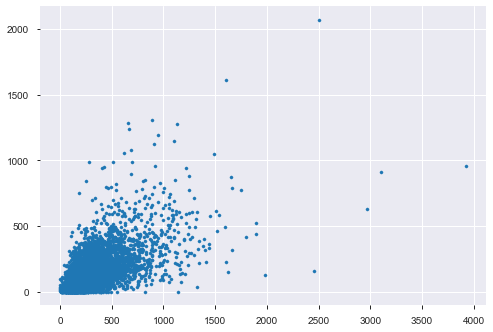

In [25]:
plt.scatter(x=Y.cardspent , y=Y.card2spent, s=10)

In [26]:
lncard1 = np.log(Y.cardspent)
lncard2 = np.log(Y.card2spent)
lnY = pd.concat([lncard1,lncard2],axis=1)
lnY = lnY.apply(outlier_miss_treat)

C:\Users\guru\Anaconda3\lib\site-packages\pandas\core\series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [27]:
lnY.card2spent[lnY.card2spent == -np.inf] = lnY.card2spent.median()

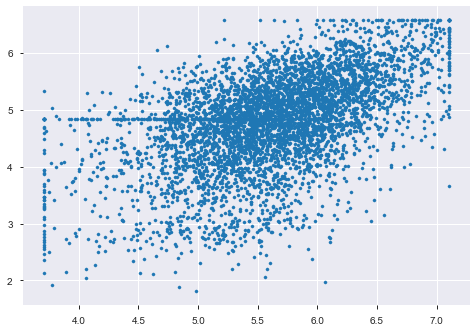

In [28]:
plt.scatter(x=lnY.cardspent , y=lnY.card2spent, s=10)

In [29]:
Y.cardspent.skew(), lnY.cardspent.skew()

(3.051236650585871, -0.2533463992746118)

In [30]:
Y.card2spent.skew(), lnY.card2spent.skew()

(2.801163008802474, -0.5013440360271303)

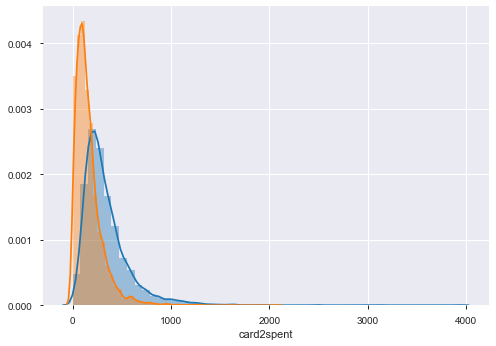

In [31]:
sns.distplot(Y.cardspent)
sns.distplot(Y.card2spent)

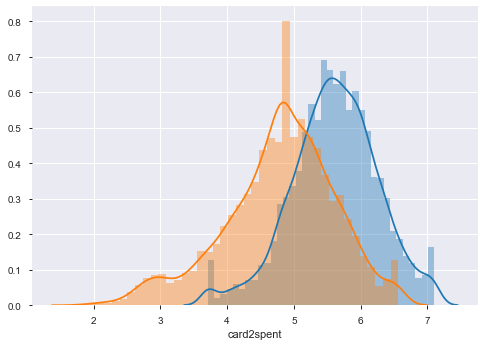

In [32]:
sns.distplot(lnY.cardspent)
sns.distplot(lnY.card2spent)

Correlation

In [33]:
import scipy.stats as stats

In [34]:
stats.stats.pearsonr(Y.cardspent, Y.card2spent)

(0.5866102332257316, 0.0)

In [35]:
stats.stats.pearsonr(lnY.cardspent, lnY.card2spent)

(0.5288709791547939, 0.0)

In [36]:
print(np.corrcoef(lnY.cardspent, lnY.card2spent))

[[1.         0.52887098]
 [0.52887098 1.        ]]


In [37]:
 stats.f_oneway(Y.cardspent, Y.card2spent)

F_onewayResult(statistic=1907.4778039492771, pvalue=0.0)

In [38]:
 stats.f_oneway(lnY.cardspent, lnY.card2spent)

F_onewayResult(statistic=3024.9352362876057, pvalue=0.0)

### ----------------------------------------------------------------------------------------------------------------------------

## 2 Data Preparation

### 2.1 Outlier and Missing value treatment

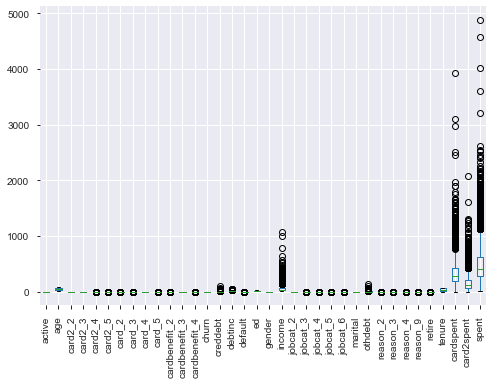

In [39]:
pd.concat([X,Y],axis=1).plot(kind='box')
plt.xticks(rotation=90)
plt.show()

In [40]:
X = X.apply(outlier_miss_treat)
Y = Y.apply(outlier_miss_treat)

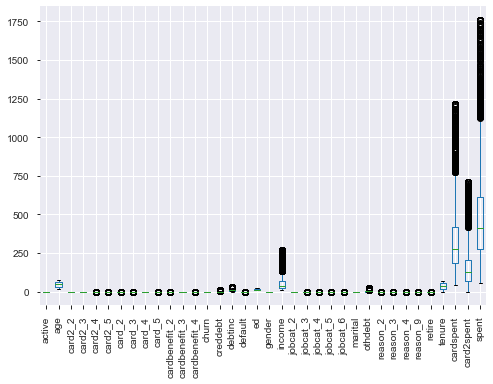

In [41]:
data_otms = pd.concat([X,Y],axis=1)
data_otms.plot(kind='box')
plt.xticks(rotation=90)
plt.show()

### 2.2 Determining the Assumptions

As the problem is identified as regression, We choose the following algorithms for the model.<br>
> Linear Regression 
- Y has to be Normally Distributed
- X and Y should be linearly related
- No multicollinearity between Xs
- Y must be homoscedastic

> Random Forest Regressor <br>
> XGBoost Regressor <br>
> Support Vector Regressor <br>
- No assumptions 


Checking if Y is Normally Distributed for applying the Linear Regression

In [42]:
Y.skew()

cardspent     1.645523
card2spent    1.704283
spent         1.615173
dtype: float64

In [43]:
 Y.kurtosis()

cardspent     3.234293
card2spent    3.623954
spent         3.111286
dtype: float64

### ----------------------------------------------------------------------------------------------------------------------------

## 3 Feature Reduction 

### 3.1 Feature reduction considering only Xs

Methods <br>
> 1 Correlation between Xs <br>
> 2 VIF <br>
> 3 PCA

### 3.1.1 Correlation between Xs

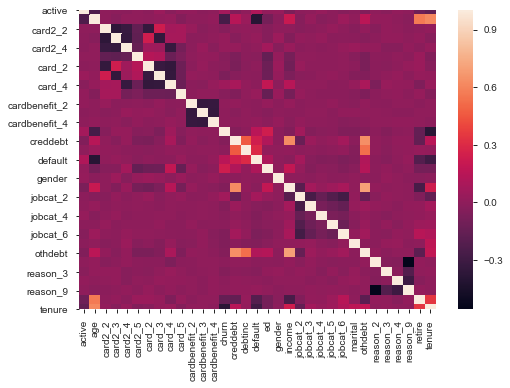

In [44]:
#Corr_matrix creation
corr_matrix = X.corr()
#corr_matrix.to_csv('corrm.csv')

# visualize correlation matrix in Seaborn using a heatmap
sns.heatmap(X.corr())

### 3.1.2 Feature Reduction using PCA

**i Feature scaling**

In [45]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

fit() ------------------> just calculates the parameters (e.g. μ and σ in case of StandardScaler) <br>
transform() ------------> helps to apply the scaling based on the calculated parameters from fit()

In [46]:
X_scaled = sc.fit_transform(X) 

**ii Applying PCA** 

In [47]:
from sklearn.decomposition import PCA
pca = PCA(n_components = None)

In [48]:
X_scaled = pca.fit_transform(X_scaled)

Eigen value

In [49]:
pca.explained_variance_    #20

array([2.92231437, 2.59114328, 1.93101536, 1.74784935, 1.65227743,
       1.44783979, 1.35318583, 1.33676325, 1.30728325, 1.17483907,
       1.16226296, 1.1340768 , 1.11006756, 1.06758122, 1.02346254,
       1.01134042, 0.99028878, 0.96393909, 0.90053046, 0.86014481,
       0.79298167, 0.76044118, 0.68944425, 0.58962358, 0.42029009,
       0.35582728, 0.34145303, 0.32559893, 0.2991543 , 0.27091293,
       0.21383224, 0.15859637, 0.10023986])

Variance explained by each PC in Cumulative Percentage 

In [50]:
np.cumsum(pca.explained_variance_ratio_) #17

array([0.08853727, 0.16704106, 0.22554497, 0.27849951, 0.32855851,
       0.37242367, 0.4134211 , 0.45392098, 0.4935277 , 0.52912176,
       0.56433481, 0.5986939 , 0.63232558, 0.66467006, 0.69567787,
       0.72631842, 0.75632117, 0.7855256 , 0.81280895, 0.83886873,
       0.86289367, 0.88593273, 0.9068208 , 0.92468461, 0.93741813,
       0.94819862, 0.95854361, 0.96840827, 0.97747174, 0.98567958,
       0.99215805, 0.99696304, 1.        ])

Selecting the Number of Principal components based on <br>
Cumulative percentage of variance > 75% <br>
Eigen value > 0.8

Based on the above criteria for selection we conclude **Number of PC = 20** 

Fitting the model again with the select number PC

In [51]:
pca_final = PCA(n_components=20)

In [52]:
pca_final = pca_final.fit(X_scaled)

In [53]:
pca_final.explained_variance_

array([2.92231437, 2.59114327, 1.93101535, 1.74784934, 1.65227741,
       1.44783978, 1.35318581, 1.3367632 , 1.30728323, 1.1748385 ,
       1.16226285, 1.1340756 , 1.11006751, 1.06758115, 1.02346237,
       1.01133932, 0.99028872, 0.96393768, 0.90052965, 0.8601408 ])

In [54]:
np.cumsum(pca_final.explained_variance_ratio_)

array([0.08853727, 0.16704106, 0.22554497, 0.27849951, 0.32855851,
       0.37242367, 0.4134211 , 0.45392097, 0.49352769, 0.52912174,
       0.56433478, 0.59869383, 0.63232552, 0.66466999, 0.6956778 ,
       0.72631831, 0.75632106, 0.78552545, 0.81280877, 0.83886843])

Dimension Reduction 

In [55]:
# Applying the pca model on the scaled train data, which gives the array with specified number of PCs
reduced_factors = pca_final.transform(X_scaled) #----------->    this gives the factors

In [56]:
F = [] 
for i in list(range(1,21)):
    F.append('F' + str(i))  

In [57]:
dimensions = pd.DataFrame(reduced_factors, columns=F);
dimensions.head(2)

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20
0,-1.655390,2.068272,1.294282,1.733855,-0.603525,1.248394,-0.350040,-0.133504,0.444052,1.175452,2.450111,-0.408229,-0.953110,-0.490281,-1.057519,0.230483,0.656233,-0.167377,2.042286,1.017334
1,-1.189938,1.790828,-0.893665,2.176425,-0.618667,0.224186,1.300405,-0.090794,-1.130004,-0.119846,-0.742599,-0.223649,-0.187029,0.041251,0.902714,0.305317,-0.390736,0.739535,-1.295876,-0.460595


Factor Loading Matrix / Component loadings

Loadings=Eigenvectors * sqrt(Eigenvalues)

In [58]:
eigen_vector = pca_final.components_.T

In [59]:
eigen_value = pca_final.explained_variance_

In [60]:
Factor_loading_matrix = pd.DataFrame((eigen_vector * np.sqrt(eigen_value)).T,columns=X.columns).T

In [61]:
Factor_loading_matrix;

In [62]:
#Factor_loading_matrix.to_excel('Factor_Loading_matrix_20.xlsx')

***Selected Features from the Factor Loading Matrix***

In [63]:
selected_vars_pca = ['active','age','card2_2','card2_3','card2_4','card2_5','card_2','card_3','card_4','card_5','cardbenefit_2','cardbenefit_3','cardbenefit_4','churn','creddebt','debtinc','default','ed','gender','income']

In [64]:
X.columns.difference(selected_vars_pca) #Excluded variables

Index(['jobcat_2', 'jobcat_3', 'jobcat_4', 'jobcat_5', 'jobcat_6', 'marital',
       'othdebt', 'reason_2', 'reason_3', 'reason_4', 'reason_9', 'retire',
       'tenure'],
      dtype='object')

### 3.1.3 Feature Reduction using VIF

In [65]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

VIF = [variance_inflation_factor(X.values,i) for i in range(X.shape[1])]

In [66]:
VIF_results = pd.concat([pd.Series(X.columns), pd.Series(VIF)],axis=1)
VIF_results.columns = ['Feature','VIF']
VIF_results = VIF_results.sort_values('VIF',ascending=False) 

***Selected Features from the VIF***

In [67]:
selected_vars_vif = list(VIF_results[VIF_results.VIF > 5].Feature)

In [68]:
X.columns.difference(selected_vars_vif) #Excluded variables

Index(['active', 'card2_2', 'card2_3', 'card2_4', 'card2_5', 'card_2',
       'card_3', 'card_4', 'card_5', 'cardbenefit_2', 'cardbenefit_3',
       'cardbenefit_4', 'churn', 'creddebt', 'default', 'gender', 'jobcat_2',
       'jobcat_3', 'jobcat_4', 'jobcat_5', 'jobcat_6', 'marital', 'reason_2',
       'reason_3', 'reason_4', 'retire'],
      dtype='object')

Combining all the selected Features based on Xs 

In [69]:
selected_vars_final1 = selected_vars_pca + selected_vars_vif 

In [70]:
selected_vars_final1= list(selected_vars_final1)

In [71]:
#Common Features
len(pd.Series(selected_vars_pca)[pd.Series(selected_vars_pca).isin(selected_vars_vif)]) 

4

In [72]:
print('# :',len(set(selected_vars_final1)),'\n',selected_vars_final1)

# : 23 
 ['active', 'age', 'card2_2', 'card2_3', 'card2_4', 'card2_5', 'card_2', 'card_3', 'card_4', 'card_5', 'cardbenefit_2', 'cardbenefit_3', 'cardbenefit_4', 'churn', 'creddebt', 'debtinc', 'default', 'ed', 'gender', 'income', 'age', 'ed', 'income', 'debtinc', 'reason_9', 'tenure', 'othdebt']


### ----------------------------------------------------------------------------------------------------------------------------

## 3.2 Feature Reduction based on X and Y

Since the Prediction we have to make here is "cardspent" (primary card spent) and "card2spent" (secondary card spent), <br> we will perform this Feature Reduction Techniques for the sum these variables <br>

15 Features are selected in each method

### 3.2.1 RFE

In [73]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor

In [74]:
Dt = DecisionTreeRegressor()

In [75]:
rfe = RFE(Dt, n_features_to_select=15)
rfe = rfe.fit(X, Y.spent)

In [76]:
select_cols = rfe.get_support()
selected_vars_rfe = list(X.columns[select_cols])

In [77]:
selected_vars_rfe;

### 3.2.2 F-regression

In [78]:
from sklearn.feature_selection import f_regression
F_values, p_values  = f_regression(X, Y.spent ) # Will give two arrays of f and p values

In [79]:
F_values = pd.Series(F_values)
p_values = pd.Series(p_values)
cols = pd.Series(X.columns)

f_vars = pd.concat([cols,F_values,p_values],axis=1)
f_vars.columns = ['col','f_val','p_val']

In [80]:
f_vars = f_vars.sort_values(by=['f_val'],ascending=False)
selected_vars_freg = list(f_vars.col.head(15))

### 3.2.3 Select K best

In [81]:
from sklearn.feature_selection import SelectKBest, f_classif, chi2 
selector = SelectKBest(f_classif, k=15) # similarly can do for Chi square
selector.fit(X, Y.spent)

SelectKBest(k=15, score_func=<function f_classif at 0x0000000005470D38>)

In [82]:
K_Best = X.columns[selector.get_support()]
selected_vars_Kbest = list(K_Best)

#### Miscellaneous

The Important features identified by applying the Decision Tree Regressor on the entire dataset with Best parameters <br> (in descending order of importance) <br>
card	income	inccat	card2	hourstv	lninc	polview	debtinc	age	othdebt	carvalue	lnlongmon	lnothdebt	ed	lnlongten	cardten	address	lncreddebt	longmon	card2type	tollmon	lnwiremon	cardbenefit	internet	cars	commute	equipten

### 3.3 Combining the Selected Features 

In [83]:
selected_vars_final2 = selected_vars_rfe + selected_vars_freg + selected_vars_Kbest

### ----------------------------------------------------------------------------------------------------------------------------

### 3.4 Combining the Final Feature from (only Xs) and (X and Y) methods

In [84]:
selected_vars_final = list(set(selected_vars_final1 +  selected_vars_final2))

In [85]:
print(selected_vars_final)

['creddebt', 'churn', 'cardbenefit_3', 'cardbenefit_2', 'card2_3', 'default', 'othdebt', 'cardbenefit_4', 'card2_4', 'retire', 'tenure', 'card_2', 'marital', 'card_4', 'ed', 'card2_2', 'card2_5', 'card_5', 'gender', 'income', 'card_3', 'jobcat_2', 'reason_2', 'debtinc', 'reason_9', 'age', 'active']


In [86]:
selected_vars_final = ['reason_9', 'marital', 'jobcat_2', 'churn', 'reason_2', 'card_3', 'tenure', 'default', 'card_5', 'cardbenefit_2', 'card2_5', 'card2_4', 'card2_2', 'card_2', 'cardbenefit_4', 'debtinc', 'cardbenefit_3', 'gender', 'creddebt', 'income', 'card_4', 'active', 'ed', 'retire', 'card2_3', 'age', 'othdebt']

In [87]:
X_final = X[selected_vars_final]

In [88]:
X_final.head()

,reason_9,marital,jobcat_2,churn,reason_2,card_3,tenure,default,card_5,cardbenefit_2,...,gender,creddebt,income,card_4,active,ed,retire,card2_3,age,othdebt
0,1,0,0,1,0,1,5,1,0,0,...,1,1.200909,31.0,0,0,15,0,0,20,2.240091
1,1,0,1,0,0,0,39,1,0,0,...,0,1.222020,15.0,0,1,17,0,0,22,1.567980
2,0,1,1,0,1,0,65,0,0,0,...,1,0.928620,35.0,0,0,14,0,0,67,2.536380
3,1,1,1,0,0,0,36,1,0,0,...,0,0.033160,20.0,0,1,16,0,1,23,1.117200
4,1,1,1,0,0,0,21,0,0,0,...,0,0.214659,23.0,1,1,16,0,0,26,0.176341


In [89]:
Y.head()

,cardspent,card2spent,spent
0,81.66,67.80,149.46
1,42.60,34.94,77.54
2,184.22,175.75,359.97
3,340.99,18.42,359.41
4,255.10,252.73,507.83


In [90]:
X.shape, X.columns

((5000, 33),
 Index(['active', 'age', 'card2_2', 'card2_3', 'card2_4', 'card2_5', 'card_2',
        'card_3', 'card_4', 'card_5', 'cardbenefit_2', 'cardbenefit_3',
        'cardbenefit_4', 'churn', 'creddebt', 'debtinc', 'default', 'ed',
        'gender', 'income', 'jobcat_2', 'jobcat_3', 'jobcat_4', 'jobcat_5',
        'jobcat_6', 'marital', 'othdebt', 'reason_2', 'reason_3', 'reason_4',
        'reason_9', 'retire', 'tenure'],
       dtype='object'))

### ----------------------------------------------------------------------------------------------------------------------------

### 3.5 Splitting the dataset in to test and train

In [91]:
y = Y.spent
lny = np.log(y)

In [92]:
np.max(lny)

7.473127268157884

In [93]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, lny, test_size = 0.3, random_state = 123)

### --------------------------------------------- End of Data Preparation ---------------------------------------------

## 4 Model Implementation

The Algorithms used for model building are, <br>
> Ridge, Lasso, ELasticNet <br>
> Random Forest Regressor <br>
> XGBoost Regressor<br>
> Support Vector Regressor<br>

### Linear Regression

In [94]:
#Importing packages
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

In [95]:
from sklearn.linear_model import Ridge,Lasso

In [96]:
eva_dict ={}

In [97]:
def eva_met (algorithm,train_pred,test_pred ):
    t1 = np.exp(train_pred)
    t2 = np.exp(test_pred)
    t3 = np.exp(y_train)
    t4 = np.exp(y_test)

    print(algorithm)

    #Mean Absolute Percentage Error 
    print("MAPE values for actual training and testing data :")
    MAPE_train = np.mean(np.abs(t3 - t1)/t3)
    print(MAPE_train)
    MAPE_test = np.mean(np.abs(t4- t2)/t4)
    print(MAPE_test)

    #Root Mean Squared error
    print("\nRMSE values for actual training and testing data :")
    RMSE_train = np.sqrt(mean_squared_error(t3,t1))
    print(RMSE_train)
    RMSE_test =np.sqrt(mean_squared_error(t4,t2))
    print(RMSE_test)
    
    eva_dict.update({algorithm : [MAPE_train,MAPE_test,RMSE_train,RMSE_test]})

### Ridge

In [98]:
Ridge_Reg = Ridge(alpha=0.01)
Ridge_Reg.fit(X_train,y_train)

Ridge(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [99]:
#Predicting values for both training and testing data sets
rid_train_pred=Ridge_Reg.predict(X_train)
rid_test_pred=Ridge_Reg.predict(X_test)

In [100]:
eva_met ('Ridge',rid_train_pred,rid_test_pred)

Ridge
MAPE values for actual training and testing data :
0.4890222170100434
0.45235669621054164

RMSE values for actual training and testing data :
272.84869007679634
272.40922622855294


In [101]:
pd.concat([pd.Series(X_final.columns),pd.Series((Ridge_Reg.coef_))],axis=1).sort_values(by=[1],ascending=False).head();

### Lasso

In [102]:
Lasso_Reg = Lasso(alpha=0.01)
Lasso_Reg.fit(X_train,y_train)

Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [103]:
#Predicting values for both training and testing data sets
las_train_pred=Lasso_Reg.predict(X_train)
las_test_pred=Lasso_Reg.predict(X_test)

In [104]:
eva_met ('Lasso',las_train_pred,las_test_pred)

Lasso
MAPE values for actual training and testing data :
0.5198829837119091
0.4774571919281728

RMSE values for actual training and testing data :
290.8521367331602
290.66543304178185


### ElasticNet

In [105]:
from sklearn.linear_model import ElasticNet

In [106]:
Elastic_Reg = ElasticNet(alpha=0.01)
Elastic_Reg.fit(X_train,y_train)

ElasticNet(alpha=0.01, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [107]:
#Predicting values for both training and testing data sets
els_train_pred=Elastic_Reg.predict(X_train)
els_test_pred=Elastic_Reg.predict(X_test)

In [108]:
eva_met ('ElasticNet',els_train_pred,els_test_pred)

ElasticNet
MAPE values for actual training and testing data :
0.5036447440195508
0.46234724046719605

RMSE values for actual training and testing data :
283.0210192679951
282.3265413092214


### 4.1 Random Forest

In [109]:
from sklearn.ensemble import RandomForestRegressor

In [110]:
'''pargrid_ada = {'n_estimators': [300,350],
               'max_depth':[4,8,10]}'''

pargrid_ada = {'max_depth': [8], 'n_estimators': [350]}
data_rf = GridSearchCV(estimator=RandomForestRegressor(), 
                        param_grid=pargrid_ada, 
                        cv=5,n_jobs=-1)
data_rf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [8], 'n_estimators':

In [111]:
data_rf.best_params_

{'max_depth': 8, 'n_estimators': 350}

In [112]:
#Predicting values for both training and testing data sets
rf_train_pred=data_rf.predict(X_train)
rf_test_pred=data_rf.predict(X_test)

In [113]:
eva_met ('Random Forest',rf_train_pred,rf_test_pred)

Random Forest
MAPE values for actual training and testing data :
0.4001202834955637
0.482776389754272

RMSE values for actual training and testing data :
240.96771331832687
285.51608329677555


### SVR

In [114]:
#Importing required modules
from sklearn.svm import SVR

In [115]:
#Model building using svm 
tuned_parameters = [{#'C': [1,5],
                    'gamma':[0.01],
                    'kernel':['linear'],
                    'epsilon':[1.25]}]

svr = GridSearchCV(SVR(),tuned_parameters,cv=5,n_jobs=-1)
#svr = SVR()
svr.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='auto_deprecated', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='warn', n_jobs=-1,
             param_grid=[{'epsilon': [1.25], 'gamma': [0.01],
                          'kernel': ['linear']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [116]:
svr.best_params_

{'epsilon': 1.25, 'gamma': 0.01, 'kernel': 'linear'}

In [117]:
svr_test_pred = svr.predict(X_test)
svr_train_pred = svr.predict(X_train)

In [118]:
eva_met ('SVR',svr_train_pred,svr_test_pred)

SVR
MAPE values for actual training and testing data :
0.4597436856040626
0.43411297404073435

RMSE values for actual training and testing data :
299.92487914597933
300.8863336094889


### XGBoost

In [119]:
#Importing Required packages
import xgboost

In [120]:
pargrid_xg = {'n_estimators': [38],
               'max_depth':[4]}

gscv_xg = GridSearchCV(estimator=xgboost.XGBRegressor(), 
                        param_grid=pargrid_xg, 
                        cv=5,n_jobs=-1)

data_xg=gscv_xg.fit(X_train, y_train)

[21:34:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\guru\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [121]:
gscv_xg.best_params_

{'max_depth': 4, 'n_estimators': 38}

In [122]:
#Predicting values for both training and testing data sets
xg_train_pred=data_xg.predict(X_train)
xg_test_pred=data_xg.predict(X_test)

In [123]:
eva_met ('XGboost',xg_train_pred,xg_test_pred)

XGboost
MAPE values for actual training and testing data :
0.4344944927890841
0.43039491116434425

RMSE values for actual training and testing data :
285.88574371852326
292.84150405216633


In [124]:
train_out = pd.concat([pd.Series(y_train).reset_index(drop=True),pd.Series(rf_train_pred),pd.Series(svr_train_pred),pd.Series(xg_train_pred)
                      ,pd.Series(rid_train_pred),pd.Series(las_train_pred),pd.Series(els_train_pred)], axis=1)
train_out.columns = ['y_train','RF','SVR','XG','RID','LAS','ELS']
train_out = train_out.apply(np.exp)
train_out.tail(5)

,y_train,RF,SVR,XG,RID,LAS,ELS
3495,207.19,333.651869,219.201410,279.842468,300.263146,336.639931,318.539480
3496,177.01,322.042669,245.421586,321.612488,312.640079,365.220924,355.263268
3497,567.87,393.075704,259.974356,344.479736,324.906141,389.988149,375.080218
3498,302.95,318.749163,283.119624,319.614349,352.357373,358.313705,352.134491
3499,452.38,320.303434,306.308416,305.954193,320.698019,346.200001,350.531206


In [125]:
test_out = pd.concat([pd.Series(y_test).reset_index(drop=True),pd.Series(rf_test_pred),pd.Series(svr_test_pred),pd.Series(xg_test_pred)
                      ,pd.Series(rid_test_pred),pd.Series(las_test_pred),pd.Series(els_test_pred)], axis=1)
test_out.columns = ['y_test','RF','SVR','XG','RID','LAS','ELS']
test_out = test_out.apply(np.exp)
test_out.tail(5)

,y_test,RF,SVR,XG,RID,LAS,ELS
1495,403.05,562.049248,456.859141,468.784698,571.223832,475.846787,505.314661
1496,119.53,363.915967,245.888171,289.207886,309.733172,426.594362,383.444198
1497,216.28,380.205281,275.636622,354.826447,332.861944,372.474586,364.408194
1498,354.14,348.373197,459.323879,390.564331,508.087292,442.430638,460.717302
1499,328.28,310.294292,225.120762,302.311005,304.983157,329.824857,322.040700


In [126]:
pd.DataFrame(eva_dict, index = ['MAPE_train', 'MAPE_test', 'RMSE_train', 'RMSE_test'])

,Ridge,Lasso,ElasticNet,Random Forest,SVR,XGboost
MAPE_train,0.489022,0.519883,0.503645,0.400120,0.459744,0.434494
MAPE_test,0.452357,0.477457,0.462347,0.482776,0.434113,0.430395
RMSE_train,272.848690,290.852137,283.021019,240.967713,299.924879,285.885744
RMSE_test,272.409226,290.665433,282.326541,285.516083,300.886334,292.841504


**Conclusion based on the Evalution Metrics:** <br>
It is found that the XGBoost and SVM models performed better comparatively on considering the evaluation metrics MAPE and RMSE of train and test.


### ----------------------------------------------------------------------------------------------------------------------------

### Finding the Optimum Credit for the Card Holders

The Credit Limit can be set as 3 times the Total spent (Primary Spent + Secondary spent) for each Card Holder<br>
> Credit_limit = 3 * (cardspent + card2spent) 

In [127]:
Y['credit_limit'] = Y['spent'] * 3

The minimum and maximum credit limits

In [128]:
Y.credit_limit.min(), Y.credit_limit.max()

(174.5928, 5280.307200000007)

### ---------------------------------------------------------------------------------------------------------------------------

## Identifying the Key Drivers for the Spend

Preparing the dataset with proper Variables Name for better interpretation:

Encode catagorical variables
card	
    1	American Express
	2	Visa
	3	Mastercard
	4	Discover
	5	Other
card2	
    1	American Express
	2	Visa
	3	Mastercard
	4	Discover
	5	Other
cardbenefit	
    1	None
	2	Cash back
	3	Airline miles
	4	Other
jobcat	
    1	Managerial and Professional
	2	Sales and Office
	3	Service
	4	Agricultural and Natural Resources
	5	Precision Production, Craft, Repair
	6	Operation, Fabrication, General Labor
reason	
    1	Prices
	2	Convenience
	3	Service
	4	Other
	8	N/A
	9	No response

In [129]:
x_final_vars = list(X_final.columns)

In [130]:
x_final_vars.sort()

In [131]:
X_final_crlt = X_final[x_final_vars]

In [132]:
X_final_crlt.columns

Index(['active', 'age', 'card2_2', 'card2_3', 'card2_4', 'card2_5', 'card_2',
       'card_3', 'card_4', 'card_5', 'cardbenefit_2', 'cardbenefit_3',
       'cardbenefit_4', 'churn', 'creddebt', 'debtinc', 'default', 'ed',
       'gender', 'income', 'jobcat_2', 'marital', 'othdebt', 'reason_2',
       'reason_9', 'retire', 'tenure'],
      dtype='object')

Assigning the proper vars names based on the Data dictionary

In [133]:
x_final_dict = {'card_2':'Visa_1',
                'card_3':'Mastercard_1',
                'card_4':'Discover_1',
                'card_5':'Other_1',
                'card2_2':'Visa_2',
                'card2_3':'Mastercard_2',
                'card2_4':'Discover_2',
                'card2_5':'Other_2',
                'cardbenefit_2':'Cash_back_ben', 
                'cardbenefit_3':'Airline_miles_ben',
                'cardbenefit_4':'Other_ben', 
                'jobcat_2':'Sales_and_Office_job',
                'reason_2':'Convenience',
                'reason_9':'No_response'}              

In [134]:
x_final_crlt_new = []
for i in X_final_crlt.columns:
    if x_final_dict.get(i) is not None :
        x_final_crlt_new.append(x_final_dict.get(i))
    else:
        x_final_crlt_new.append(i)

In [135]:
X_final_crlt_new = X_final_crlt.copy()

In [136]:
X_final_crlt_new.columns = x_final_crlt_new

In [137]:
X_final_crlt_new.head()

,active,age,Visa_2,Mastercard_2,Discover_2,Other_2,Visa_1,Mastercard_1,Discover_1,Other_1,...,ed,gender,income,Sales_and_Office_job,marital,othdebt,Convenience,No_response,retire,tenure
0,0,20,0,0,0,1,0,1,0,0,...,15,1,31.0,0,0,2.240091,0,1,0,5
1,1,22,0,0,1,0,1,0,0,0,...,17,0,15.0,1,0,1.567980,0,1,0,39
2,0,67,0,0,1,0,1,0,0,0,...,14,1,35.0,1,1,2.536380,1,0,0,65
3,1,23,0,1,0,0,1,0,0,0,...,16,0,20.0,1,1,1.117200,0,1,0,36
4,1,26,0,0,0,0,0,0,1,0,...,16,0,23.0,1,1,0.176341,0,1,0,21


##### We will apply the Statsmodel Linear Regression to come up with the Coeficient of the Variables 

In [138]:
All_crlt = pd.concat([X_final_crlt_new, Y],axis=1)

In [139]:
All_crlt['lnspent'] = np.log(All_crlt.spent)

In [140]:
All_crlt_train,All_crlt_test = train_test_split(All_crlt, test_size=0.3, random_state=123)

In [141]:
All_crlt_train.shape,All_crlt_test.shape

((3500, 32), (1500, 32))

In [142]:
import statsmodels.formula.api as smf

In [143]:
All_crlt_train.columns

Index(['active', 'age', 'Visa_2', 'Mastercard_2', 'Discover_2', 'Other_2',
       'Visa_1', 'Mastercard_1', 'Discover_1', 'Other_1', 'Cash_back_ben',
       'Airline_miles_ben', 'Other_ben', 'churn', 'creddebt', 'debtinc',
       'default', 'ed', 'gender', 'income', 'Sales_and_Office_job', 'marital',
       'othdebt', 'Convenience', 'No_response', 'retire', 'tenure',
       'cardspent', 'card2spent', 'spent', 'credit_limit', 'lnspent'],
      dtype='object')

active+age+Visa_2+Mastercard_2+Discover_2+Other_2,Visa_1+Mastercard_1+Discover_1+Other_1+Cash_back_ben,Airline_miles_ben+Other_ben+churn+creddebt+debtinc,default+ed+gender+income+Sales and Office+marital,othdebt+Convenience+No_response+retire+tenure,cardspent+card2spent+spent+credit_limit

In [144]:
formula = 'lnspent~active+age+Visa_2+Mastercard_2+Discover_2+Other_2+Visa_1+Mastercard_1+Discover_1+Other_1+Cash_back_ben+Airline_miles_ben+Other_ben+churn+creddebt+debtinc+default+ed+gender+income+Sales_and_Office_job+marital+othdebt+Convenience+No_response+retire+tenure'

In [145]:
# Initializing and fiting the model
model = smf.ols(formula, data=All_crlt_train).fit()

In [146]:
All_crlt_train['pred'] = pd.DataFrame(model.predict(All_crlt_train))

C:\Users\guru\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [147]:
All_crlt_train[['lnspent','pred']].head()

,lnspent,pred
4036,6.504498,6.148266
2883,5.203072,5.834477
4162,5.391534,5.589902
4640,6.214628,5.962561
2430,7.473127,6.125187


In [148]:
All_crlt_test['pred'] = pd.DataFrame(model.predict(All_crlt_test))

C:\Users\guru\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [149]:
t1 = np.exp(All_crlt_train.pred)
t2 = np.exp(All_crlt_test.pred)
t3 = np.exp(All_crlt_train.lnspent)
t4 = np.exp(All_crlt_test.lnspent)
algorithm = 'Linear_Regression_stats'
print(algorithm)

#Mean Absolute Percentage Error 
print("MAPE values for actual training and testing data :")
MAPE_train = np.mean(np.abs(t3 - t1)/t3)
print(MAPE_train)
MAPE_test = np.mean(np.abs(t4- t2)/t4)
print(MAPE_test)

#Root Mean Squared error
print("\nRMSE values for actual training and testing data :")
RMSE_train = np.sqrt(mean_squared_error(t3,t1))
print(RMSE_train)
RMSE_test =np.sqrt(mean_squared_error(t4,t2))
print(RMSE_test)
    
eva_dict.update({algorithm : [MAPE_train,MAPE_test,RMSE_train,RMSE_test]})

Linear_Regression_stats
MAPE values for actual training and testing data :
0.48902197355032223
0.4523581039972904

RMSE values for actual training and testing data :
272.84780396898117
272.40867505186634


In [150]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                lnspent   R-squared:                       0.327
Model:                            OLS   Adj. R-squared:                  0.322
Method:                 Least Squares   F-statistic:                     62.50
Date:                Tue, 24 Dec 2019   Prob (F-statistic):          3.88e-274
Time:                        21:34:05   Log-Likelihood:                -2798.9
No. Observations:                3500   AIC:                             5654.
Df Residuals:                    3472   BIC:                             5826.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                6.5437 

The variables identified as not useful are<br>
>age <br>
Cash_back_ben<br>
Airline_miles_ben<br>
Other_ben<br>
creddebt<br>
debtinc<br>
default<br>
ed<br>
marital<br>
othdebt<br>
tenure

In [151]:
formula = 'lnspent~active+Visa_2+Mastercard_2+Discover_2+Other_2+Visa_1+Mastercard_1+Discover_1+Other_1+churn+ed+gender+income+Sales_and_Office_job+Convenience+No_response+retire'

In [152]:
model = smf.ols(formula, data=All_crlt_train).fit()

In [153]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                lnspent   R-squared:                       0.326
Model:                            OLS   Adj. R-squared:                  0.322
Method:                 Least Squares   F-statistic:                     98.90
Date:                Tue, 24 Dec 2019   Prob (F-statistic):          4.36e-282
Time:                        21:34:05   Log-Likelihood:                -2802.6
No. Observations:                3500   AIC:                             5641.
Df Residuals:                    3482   BIC:                             5752.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                6.6147 

**Math Equation:**  <br>
From Linear Regression Statsmodel <br>
ln_spent    =   6.6147+
active * 0.0037+
Visa_2 * -0.4038+
Mastercard_2 * -0.3775+
Discover_2 * -0.4272+
Other_2 * -0.3016+
Visa_1 * -0.594+
Mastercard_1 * -0.6117+
Discover_1 * -0.7053+
Other_1 * -0.5364+
churn * 0.0138+
ed * -0.0048+
gender * -0.0434+
income * 0.0044+
Sales_and_Office_job * -0.0172+
Convenience * 0.3565+
No_response * 0.1059


### Key Drivers Identification

#### Important features from the Ridge Regression Summary:

In [154]:
feat_imp = pd.concat([pd.Series(X_final.columns),pd.Series((Ridge_Reg.coef_))],axis=1).sort_values(by=[1],ascending=False)

In [155]:
feat_imp.columns = ['features','Coeff']

In [156]:
feat_imp;

From the Linear Regression statsmodel

Positive drivers <br>

active <br>
churn <br>
income <br>
Convenience <br>
No_response

Negative drivers <br>

Mastercard_2 <br>
Discover_2 <br> 
ed <br>
gender <br>
Sales_and_Office_job <br>
retire

### Conclusion on Key Drivers of Spend:

**Important Drivers** <br>

Positive Drivers
> - Reason_2 - People who use the card for the reason "convenience" tend to spend more and hence will have high Credit limit
> - Marital - If a person is married, will spend more
> - Income - High income more Spend

Negative drivers
> - People using the Discover and Mastercard have low Credit limit
> - Female spend less 
> - If a person is Retired spent less
> - People of Sales_and_Office_job spent less
